In [ ]:
# 전체데이터 상관관계분석(202501_04_clean)

In [2]:
import re
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from google.colab import files

# --- 업로드 & 로드 ---
uploaded = files.upload()
fname = next(iter(uploaded.keys()))
df = pd.read_excel(fname)

# 1) 중복 열 제거(첫 번째만 유지)
if df.columns.duplicated().any():
    dup_names = df.columns[df.columns.duplicated()].unique().tolist()
    print(f"[warn] duplicated columns dropped (keeping first): {dup_names}")
    df = df.loc[:, ~df.columns.duplicated()].copy()

# 2) 대상 열 선택: (n|u|μ|µ)g/m3 또는 ㎥ 단위 포함
unit_pat = re.compile(r"\((?:n|u|μ|µ)g\/?m3\)|\((?:n|u|μ|µ)g\/?㎥\)", flags=re.I)
target_cols = [c for c in df.columns if unit_pat.search(str(c))]
target_cols = pd.Index(target_cols).drop_duplicates().tolist()  # 방어적 중복 제거

# 3) 숫자화 + 음수→NaN (전처리에서 끝났어도 안전하게 한 번 더)
df_num = df.loc[:, target_cols].apply(pd.to_numeric, errors="coerce")
df_num = df_num.mask(df_num < 0, np.nan)

# 4) 상관계수/유의확률/표본수 테이블
rmat = pd.DataFrame(index=target_cols, columns=target_cols, dtype=float)
pmat = pd.DataFrame(index=target_cols, columns=target_cols, dtype=float)
nmat = pd.DataFrame(index=target_cols, columns=target_cols, dtype=int)

for i, c1 in enumerate(target_cols):
    s1 = df_num[c1]                      # 반드시 Series (중복 열 제거했으므로 OK)
    for j, c2 in enumerate(target_cols):
        s2 = df_num[c2]
        # 하삼각만 채움
        if j > i:
            continue
        # 대각
        if i == j:
            rmat.iat[i, j] = 1.0
            pmat.iat[i, j] = 0.0
            nmat.iat[i, j] = s1.notna().sum()
            continue

        pair = pd.concat([s1, s2], axis=1).dropna()
        n = len(pair)
        nmat.iat[i, j] = n
        # 변동성 부족 또는 표본 부족 방어
        if n < 3 or s1.nunique(dropna=True) < 2 or s2.nunique(dropna=True) < 2:
            rmat.iat[i, j] = np.nan
            pmat.iat[i, j] = np.nan
            continue

        r, p = pearsonr(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        rmat.iat[i, j] = r
        pmat.iat[i, j] = p

# 5) 별표 포맷(하삼각만)
def stars(p):
    if pd.isna(p): return ""
    return "**" if p < 0.01 else ("*" if p < 0.05 else "")

out = rmat.copy().astype(object)
for i in range(len(target_cols)):
    for j in range(len(target_cols)):
        if j > i:
            out.iat[i, j] = ""
        elif i == j:
            out.iat[i, j] = "1"
        else:
            rij = rmat.iat[i, j]; pij = pmat.iat[i, j]
            out.iat[i, j] = "NaN" if pd.isna(rij) else f"{rij:.3f}{stars(pij)}"

# 6) 저장
with pd.ExcelWriter("상관관계분석표.xlsx") as w:
    out.to_excel(w, sheet_name="pearson_r_fmt")
    rmat.to_excel(w, sheet_name="pearson_r_raw")
    pmat.to_excel(w, sheet_name="p_values")
    nmat.to_excel(w, sheet_name="pair_N")


Saving 202501_clean2.xlsx to 202501_clean2 (1).xlsx


▶ 포맷된 하삼각 상관표 (별표 포함): out


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Cd(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),1,,,,,,,
Cr(ng/m3),0.035,1,,,,,,
Co(ng/m3),0.668**,0.302**,1,,,,,
Ni(ng/m3),-0.320**,0.929**,0.001,1,,,,
As(ng/m3),NaN,NaN,NaN,NaN,1,,,
Cd(ng/m3),0.081,0.892**,0.379**,0.956**,NaN,1,,
Sb(ng/m3),-0.002,0.213**,0.139*,0.183*,NaN,0.290**,1,
Pb(ng/m3),0.607**,0.064,0.508**,-0.236**,NaN,0.107*,0.008,1


▶ 원시 상관계수 행렬(r) / p값 행렬(p) / 쌍별 표본수(N)


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Cd(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cr(ng/m3),0.035,1.000,NaN,NaN,NaN,NaN,NaN,NaN
Co(ng/m3),0.668,0.302,1.000,NaN,NaN,NaN,NaN,NaN
Ni(ng/m3),-0.320,0.929,0.001,1.000,NaN,NaN,NaN,NaN
As(ng/m3),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Cd(ng/m3),0.081,0.892,0.379,0.956,NaN,1.000,NaN,NaN
Sb(ng/m3),-0.002,0.213,0.139,0.183,NaN,0.290,1.000,NaN
Pb(ng/m3),0.607,0.064,0.508,-0.236,NaN,0.107,0.008,1.0


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Cd(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cr(ng/m3),0.509,0.000,NaN,NaN,NaN,NaN,NaN,NaN
Co(ng/m3),0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN
Ni(ng/m3),0.000,0.000,0.982,0.000,NaN,NaN,NaN,NaN
As(ng/m3),NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
Cd(ng/m3),0.086,0.000,0.000,0.000,NaN,0.000,NaN,NaN
Sb(ng/m3),0.977,0.003,0.034,0.011,NaN,0.000,0.000,NaN
Pb(ng/m3),0.000,0.241,0.000,0.000,NaN,0.033,0.905,0.0


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Cd(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cr(ng/m3),351.0,352.0,NaN,NaN,NaN,NaN,NaN,NaN
Co(ng/m3),448.0,352.0,449.0,NaN,NaN,NaN,NaN,NaN
Ni(ng/m3),325.0,325.0,326.0,326.0,NaN,NaN,NaN,NaN
As(ng/m3),448.0,352.0,449.0,326.0,449.0,NaN,NaN,NaN
Cd(ng/m3),448.0,352.0,449.0,326.0,449.0,449.0,NaN,NaN
Sb(ng/m3),231.0,199.0,232.0,191.0,232.0,232.0,232.0,NaN
Pb(ng/m3),394.0,337.0,395.0,316.0,395.0,395.0,214.0,395.0


▶ 유의(p<0.05) & 표본수≥30 상위 20쌍


,var1,var2,r,p,n,abs_r
13,Cd(ng/m3),Ni(ng/m3),0.956,0.000,326,0.956
4,Ni(ng/m3),Cr(ng/m3),0.929,0.000,325,0.929
11,Cd(ng/m3),Cr(ng/m3),0.892,0.000,352,0.892
1,Co(ng/m3),Conc(ug/m3),0.668,0.000,448,0.668
21,Pb(ng/m3),Conc(ug/m3),0.607,0.000,394,0.607
23,Pb(ng/m3),Co(ng/m3),0.508,0.000,395,0.508
12,Cd(ng/m3),Co(ng/m3),0.379,0.000,449,0.379
3,Ni(ng/m3),Conc(ug/m3),-0.320,0.000,325,0.320
2,Co(ng/m3),Cr(ng/m3),0.302,0.000,352,0.302
20,Sb(ng/m3),Cd(ng/m3),0.290,0.000,232,0.290


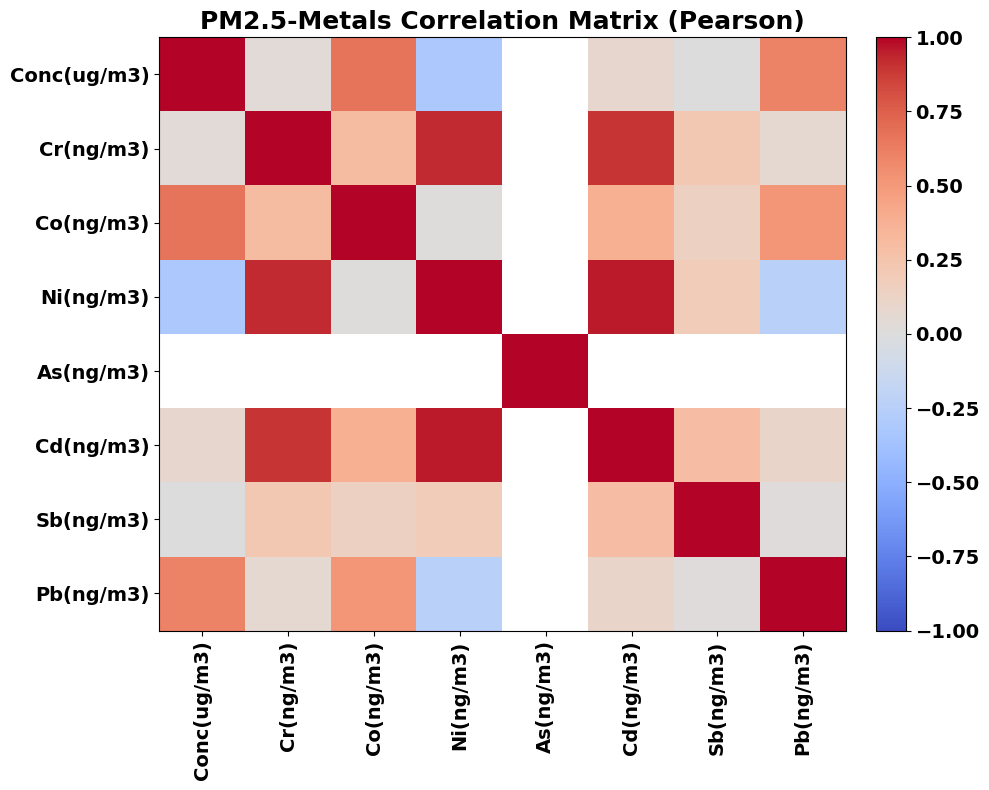

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# =========================
# 결과 확인/시각화/요약
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 인터랙티브 표 보기
try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
except Exception as e:
    print("[info] data_table 사용 불가:", e)

print("▶ 포맷된 하삼각 상관표 (별표 포함): out")
display(out_fmt)

print("▶ 원시 상관계수 행렬(r) / p값 행렬(p) / 쌍별 표본수(N)")
display(rmat_round)
display(pmat_round)
display(nmat)

# 2) 하삼각 납작화(쌍별 요약 테이블 생성)
def melt_lower(rmat: pd.DataFrame, pmat: pd.DataFrame, nmat: pd.DataFrame) -> pd.DataFrame:
    cols = rmat.columns.tolist()
    recs = []
    for i in range(len(cols)):
        for j in range(i+1):           # 하삼각만
            if i == j:
                continue               # 대각 제외
            r = rmat.iat[i, j]
            p = pmat.iat[i, j]
            n = nmat.iat[i, j]
            recs.append({
                "var1": cols[i],
                "var2": cols[j],
                "r": r,
                "p": p,
                "n": int(n) if pd.notna(n) else np.nan,
                "abs_r": abs(r) if pd.notna(r) else np.nan
            })
    df_pairs = pd.DataFrame(recs)
    return df_pairs

pairs = melt_lower(rmat, pmat, nmat)

# 3) 유의쌍 필터/정렬 (기본: p<0.05, N>=30)
ALPHA = 0.05
MIN_N = 30
sig_pairs = pairs[(pairs["p"] < ALPHA) & (pairs["n"] >= MIN_N)].sort_values("abs_r", ascending=False)

DECIMALS = 3  # 원하는 자리수로 조정

# r, p 행렬 라운드본
rmat_round = rmat.round(DECIMALS)
pmat_round = pmat.round(DECIMALS)

# 포맷용 하삼각 표(out)도 반올림 보장(별표 유지)
def _stars(p):
    if pd.isna(p): return ""
    return "**" if p < 0.01 else ("*" if p < 0.05 else "")

out_fmt = pd.DataFrame("", index=rmat.index, columns=rmat.columns, dtype=object)
for i in range(len(rmat.index)):
    for j in range(len(rmat.columns)):
        if j > i:
            out_fmt.iat[i, j] = ""      # 상삼각 공란
        elif i == j:
            out_fmt.iat[i, j] = "1"     # 대각
        else:
            rij = rmat.iat[i, j]
            pij = pmat.iat[i, j]
            out_fmt.iat[i, j] = "NaN" if pd.isna(rij) else f"{rij:.{DECIMALS}f}{_stars(pij)}"

# 쌍별 요약 테이블 라운드본
pairs_round = pairs.copy()
for c in ["r", "p", "abs_r"]:
    if c in pairs_round.columns:
        pairs_round[c] = pairs_round[c].round(DECIMALS)

sig_pairs_round = sig_pairs.copy()
for c in ["r", "p", "abs_r"]:
    if c in sig_pairs_round.columns:
        sig_pairs_round[c] = sig_pairs_round[c].round(DECIMALS)

print(f"▶ 유의(p<{ALPHA}) & 표본수≥{MIN_N} 상위 20쌍")
display(sig_pairs_round.head(20))

# 4-1) 히트맵 (전체 표시)
TITLE_SIZE = 18
TICK_SIZE  = 14
WEIGHT     = 'bold'

rmat_sym = rmat.copy().fillna(rmat.T)
R = np.ma.masked_invalid(rmat_sym.values.astype(float))

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(R, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)

# 축/제목/라벨
ax.set_title("PM2.5-Metals Correlation Matrix (Pearson)", fontsize=TITLE_SIZE, fontweight=WEIGHT)
ax.set_xticks(range(len(target_cols)))
ax.set_yticks(range(len(target_cols)))
ax.set_xticklabels(target_cols, rotation=90, ha='center', fontsize=TICK_SIZE, fontweight=WEIGHT)
ax.set_yticklabels(target_cols, fontsize=TICK_SIZE, fontweight=WEIGHT)

# 컬러바(한 번만 생성) + 글꼴 설정
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=TICK_SIZE)
for t in cbar.ax.get_yticklabels():
    t.set_fontweight(WEIGHT)
plt.tight_layout()
plt.show()

#=====================================================
# 4-2) 히트맵 (하삼각만 표시)
#R = rmat_round.values.astype(float)
#mask = np.triu(np.ones_like(R, dtype=bool), k=1)
#R_lower = np.ma.array(R, mask=mask)   # 마스크 적용
#fig, ax = plt.subplots(figsize=(10, 8))
#im = ax.imshow(R_lower, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
#im.cmap.set_bad('lightgray')          # 마스크/결측 영역 색
#ax.set_title("PM2.5-Metals Correlation Matrix (Pearson, Lower Triangle)")
#ax.set_xticks(range(len(target_cols)))
#ax.set_yticks(range(len(target_cols)))
#ax.set_xticklabels(target_cols, rotation=90)
#ax.set_yticklabels(target_cols)
#fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#plt.tight_layout()
#plt.show()
#======================================================


# 5) 엑셀/다운로드: 전체쌍 & 유의쌍 저장
with pd.ExcelWriter("상관분석_요약.xlsx") as w:
    pairs.to_excel(w, index=False, sheet_name="all_pairs")
    sig_pairs.to_excel(w, index=False, sheet_name=f"sig_pairs_p<{ALPHA}_N>={MIN_N}")

from google.colab import files
files.download("상관분석_요약.xlsx")